In [1]:
import mani_skill.envs
import gymnasium as gym
from mani_skill.utils.wrappers import RecordEpisode
from tqdm import tqdm
from IPython.display import Video
from robots.simple_fetch import SimpleFetch
from robots.ant_with_cam import CamAnt
from mani_skill.envs.tasks.control.ant import AntRobot



env = gym.make("Empty-v1", 
               render_mode="rgb_array",
               obs_mode="none",
               reward_mode="none",
               control_mode="pd_joint_delta_pos",
               robot_uids="cam_ant") # ant, cam_ant, simp_fetch
env = RecordEpisode(env, "./videos", save_trajectory=False)
print(env.agent.keyframes.keys())

import sapien
import torch


env.reset()
try:
    kf = env.agent.keyframes["rest"] # stand, rest
except:
    kf = env.agent.keyframes["stand"]
env.agent.robot.set_qpos(kf.qpos)
# env.agent.robot.set_pose(sapien.Pose([0, 0, 0.5]))

# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(100)):
    # with pd_joint_pos control we try to get the robot to maintain the same joint
    # positions as the keyframe
    action = env.action_space.sample()
    action[1:5]=0
    action[6:]=0
    action[5] = 0
    # action[0] = 0
    
    
    obs, reward, terminated, truncated, info = env.step(action)
env.flush_video("example2")
Video("./videos/example2.mp4", embed=True, width=640) # Watch our replay

/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/torch/random.py:183: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
2024-12-11 21:00:21,113 - mani_skill  - WARNING - Currently ManiSkill does not support loading plane geometries from MJCFs


These are the joint names ['pan_joint', 'hip_1', 'hip_2', 'hip_3', 'hip_4', 'tilt_joint', 'ankle_1', 'ankle_2', 'ankle_3', 'ankle_4']
These are the joint names ['pan_joint', 'hip_1', 'hip_2', 'hip_3', 'hip_4', 'tilt_joint', 'ankle_1', 'ankle_2', 'ankle_3', 'ankle_4']
dict_keys(['rest'])


100%|██████████| 100/100 [00:00<00:00, 144.04it/s]


## Test Custom Env

In [ ]:
import gymnasium as gym
from mani_skill.utils.wrappers import RecordEpisode
import mani_skill.envs
import torch
import time

from envs import soccer_play

num_envs = 256 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PlaySoccer-v1", 
               render_mode="rgb_array",
               obs_mode="rgb",
               num_envs=num_envs,
               reward_mode="dense",
               control_mode="pd_joint_pos",
               robot_uids="simp_fetch")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
print("This is the initial observation:", obs)
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

Here we are


[2024-11-21 19:26:23.783] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:23.824] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:23.824] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:23.824] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:23.824] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:24.144] [SAPIEN] [critical] /buildAgent/work/eb2f45c4acc808a0/physx/source/gpucommon/src/PxgCudaMemoryAllocator.cpp
[2024-11-21 19:26:24.245] [SAPIEN] [critical] memcpyHtoD invalid parameters!! 1

[2024-11-21 19:26:24.245] [SAPIEN] [critical] memcpyHtoD invalid parameters!! 1

[2024-11-21 19:26:24.245] [SAPIEN]

Creating the ball


[2024-11-21 19:26:24.491] [SAPIEN] [critical] prepareGpuNarrowphase GPU error! code 1 

[2024-11-21 19:26:24.592] [SAPIEN] [critical] SynchronizeStreams cuEventRecord failed with error 700

[2024-11-21 19:26:24.592] [SAPIEN] [critical] SynchronizeStreams cuStreamWaitEvent failed with error 700

[2024-11-21 19:26:24.592] [SAPIEN] [critical] memcpy failed fail!
  700
[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuEventRecord failed with error 700

[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuStreamWaitEvent failed with error 700

[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuEventRecord failed with error 700

[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuStreamWaitEvent failed with error 700

[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuEventRecord failed with error 700

[2024-11-21 19:26:24.593] [SAPIEN] [critical] SynchronizeStreams cuStreamWaitEvent failed with error 700

[2024-11

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['fetch_head'])
dict_keys(['rgb'])
torch.Size([512, 128, 128, 3])


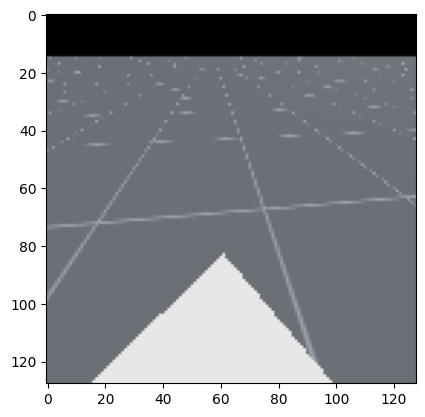

In [ ]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['fetch_head'].keys())
print(obs['sensor_data']['fetch_head']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['fetch_head']['rgb'][0].cpu().numpy())

## Record a Video (From Robot's Perspective)

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video
import envs.soccer_play as soccer_play

from robots.simple_fetch import SimpleFetch
from robots.ant_with_cam import CamAnt
from mani_skill.envs.tasks.control.ant import AntRobot



num_envs = 2 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("Empty-v1", 
               render_mode="sensors", # (for fpv use "sensors", for external use "rgb_array")
               obs_mode="rgb",
               num_envs=num_envs,
               reward_mode="none",
               control_mode="pd_joint_delta_pos",
               robot_uids="cam_ant")
env = RecordEpisode(env, "./videos", max_steps_per_video=100, save_trajectory=False)

obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    # Just Camera
    # action[:, 1:5] = 0
    # action[:, 6:] = 0
    
    # Just Legs
    action[:, 0] = 0
    action[:, 5] = 0
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # print("This is the reward: ", reward)
env.close()

Video("./videos/0.mp4", embed=True, width=1280)


/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/torch/random.py:183: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
2024-12-11 21:03:04,093 - mani_skill  - WARNING - Currently ManiSkill does not support loading plane geometries from MJCFs


These are the joint names ['pan_joint', 'hip_1', 'hip_2', 'hip_3', 'hip_4', 'tilt_joint', 'ankle_1', 'ankle_2', 'ankle_3', 'ankle_4']
These are the joint names ['pan_joint', 'hip_1', 'hip_2', 'hip_3', 'hip_4', 'tilt_joint', 'ankle_1', 'ankle_2', 'ankle_3', 'ankle_4']


/home/Morphabledrone/miniconda3/envs/mani/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_episode_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_episode_steps` for environment variables or `env.get_wrapper_attr('max_episode_steps')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate RL Video